In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [17]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [19]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)




In [20]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [23]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff2ed9eea30>,
 'station': 'USC00519397',
 'id': 1,
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0}

In [24]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

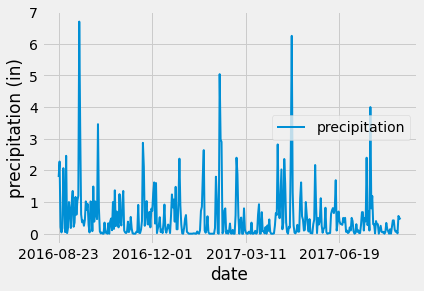

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

year_ago_date=dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_prcp=(session.query(Measurement.date,func.max(Measurement.prcp))
                  .filter(func.strftime('%Y-%m-%d',Measurement.date) >= year_ago_date)
                  .group_by(Measurement.date)
                  .all())
year_prcp
 

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df=pd.DataFrame(year_prcp, columns=['date', 'precipitation'])
prcp_df.set_index('date',inplace=True)
prcp_df.head(10)


# Sort the dataframe by date

prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(linewidth= 2, rot=0, ylabel= "precipitation (in)")
plt.show()


In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_sum_stats=(session.query(Measurement.date, Measurement.prcp)
                        .filter(Measurement.date >= year_ago_date)
                        .all()
                        )



prcp_sum_stats_df=pd.DataFrame(prcp_sum_stats, columns=['date', 'prcp'])

prcp_sum_stats_df.dropna()
prcp_sum_stats_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number stations in the dataset
count_stations = session.query(Station).count()
count_stations

9

In [28]:
count_stations = session.query(Station).count()
count_stations

first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff2f27f0ac0>,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station,func.count(Measurement.station))
                         .group_by(Measurement.station)
                         .order_by(func.count(Measurement.station).desc())
                         .all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_max_avg_temp =[Measurement.station, 
             func.min(Measurement.tobs), 
             func.max(Measurement.tobs), 
             func.avg(Measurement.tobs)]

most_active_station =(session.query(*min_max_avg_temp)
                       .filter(Measurement.station=='USC00519281')
                       .all())
most_active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

TypeError: 'str' object is not callable

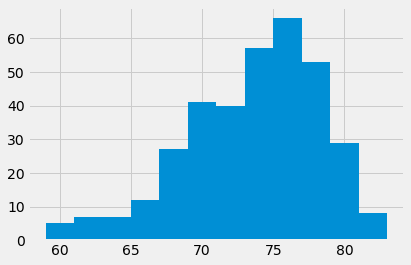

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_tobs=(session.query(Measurement.date,(Measurement.tobs))
                  .filter(func.strftime(Measurement.date) >= year_ago_date)
                  .filter(Measurement.station=='USC00519281')
                  .all())


year_tobs_df=pd.DataFrame(year_tobs)

plt.hist(year_tobs_df['tobs'],bins=12) 

plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')

plt.show()

# Close session

In [32]:
# Close Session
session.close()